# Рекуррентные нейронные сети

In [2]:
import numpy as np
import re

from tensorflow.keras.layers import Dense, SimpleRNN, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer

## Рекуррентная нейронная сеть (прогноз следующего символа)

In [2]:
with open ('./data/train_data_true.txt', 'r', encoding = 'utf-8') as f:
    text = f.read()
    text = text.replace('\\ufeff','')
    text = re.sub(r'[^А-я ]','',text) #заменяем все слова кроме кириллицы на пустые символы

In [3]:
num_characters = 34 # 33 буквы + пробел
tokenizer = Tokenizer(num_words = num_characters, char_level = True) # char_level = True - разбиение по символам
tokenizer.fit_on_texts([text])

print(tokenizer.word_index) # результат токенизации
# Преобразование текста в One-hot вектора
inp_chars= 6
data = tokenizer.texts_to_matrix(text)
n = data.shape[0] - inp_chars

X = np.array(([data[i:i+inp_chars,:] for i in range(n)]))
Y = data[inp_chars:] # предсказание следующего символа

{' ': 1, 'о': 2, 'е': 3, 'т': 4, 'и': 5, 'а': 6, 'н': 7, 'с': 8, 'в': 9, 'р': 10, 'м': 11, 'л': 12, 'ь': 13, 'д': 14, 'п': 15, 'у': 16, 'ы': 17, 'з': 18, 'я': 19, 'б': 20, 'ч': 21, 'к': 22, 'й': 23, 'ж': 24, 'г': 25, 'ш': 26, 'х': 27, 'ю': 28, 'ц': 29, 'щ': 30, 'э': 31, 'ф': 32, 'ъ': 33}


In [4]:
model= Sequential () # инициализация пустой модели
model.add(Input((inp_chars, num_characters)))
model.add(SimpleRNN(128,activation = 'tanh'))
model.add(Dense(num_characters, activation = 'softmax')) # потому что на выходе мы должны получить именно 34 вектора
model.summary()

model.compile(loss = 'categorical_crossentropy', metrics= ['accuracy'], optimizer = 'adam')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               20864     
                                                                 
 dense (Dense)               (None, 34)                4386      
                                                                 
Total params: 25250 (98.63 KB)
Trainable params: 25250 (98.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [5]:
history = model.fit(X,Y,batch_size =32, epochs =100)

Epoch 1/100
197/197 [==============================] - 3s 6ms/step - loss: 2.9785 - accuracy: 0.1830
Epoch 2/100
197/197 [==============================] - 1s 6ms/step - loss: 2.6432 - accuracy: 0.2650
Epoch 3/100
197/197 [==============================] - 1s 6ms/step - loss: 2.4553 - accuracy: 0.3103
Epoch 4/100
197/197 [==============================] - 1s 6ms/step - loss: 2.3227 - accuracy: 0.3401
Epoch 5/100
197/197 [==============================] - 1s 6ms/step - loss: 2.2267 - accuracy: 0.3595
Epoch 6/100
197/197 [==============================] - 1s 6ms/step - loss: 2.1537 - accuracy: 0.3791
Epoch 7/100
197/197 [==============================] - 1s 6ms/step - loss: 2.0972 - accuracy: 0.3869
Epoch 8/100
197/197 [==============================] - 1s 6ms/step - loss: 2.0425 - accuracy: 0.3976
Epoch 9/100
197/197 [==============================] - 1s 7ms/step - loss: 1.9963 - accuracy: 0.4130
Epoch 10/100
197/197 [==============================] - 1s 6ms/step - loss: 1.9591 - accura

In [6]:
def buidPhrase(inp_str, str_len = 50):
    for i in range(str_len):
        x=[]
        for j in range(i, i+inp_chars):
            x.append(tokenizer.texts_to_matrix(inp_str[j])) 
        x= np.array(x)
        inp = x.reshape(1,inp_chars,num_characters)
        pred = model.predict(inp)
        d = tokenizer.index_word[pred.argmax(axis =1)[0]]
        inp_str +=d
    return inp_str
res = buidPhrase('привет')

## Рекуррентная нейронная сеть (прогноз следуюбщего слова)

In [5]:
import numpy as np
import re

from tensorflow.keras.layers import Dense, SimpleRNN, Input,Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence 
from tensorflow.keras.utils import to_categorical

In [57]:
with open ('./data/text.txt', 'r', encoding = 'utf-8') as f:
    texts = f.read()
    texts = texts.replace('\ufeff','')

In [64]:
# Слова из текста фильтруются по частоте (встречаемости раз в тексте) и дальше каждому слову ставится индекс. А затем индекс в One-Hot.
# Но берутся не все слова (их тут 1667, а самые встречаемые 1000 штук)

maxWordsCount =1000
tokenizer = Tokenizer(num_words = maxWordsCount, filters = '!–"—#$%&amp;()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r«»', lower =True, split =' ',char_level = False)
tokenizer.fit_on_texts([texts])
dist = list(tokenizer.word_counts.items())
data = tokenizer.texts_to_sequences([texts])
res = to_categorical(data[0],num_classes = maxWordsCount)
print (res.shape)

inp_words = 3 # количество слов которые мы даем модели для обучения (окно)
n = res.shape[0] - inp_words

X = np.array([res[i:i+inp_words,:] for i in range(n)]) # обучающий тензор
Y = res[inp_words:,:] 

(1667, 1000)


In [76]:
model= Sequential () # инициализация пустой модели
model.add(Input((inp_words, maxWordsCount)))
model.add(SimpleRNN(128,activation = 'tanh'))
model.add(Dense(maxWordsCount, activation = 'softmax')) # потому что на выходе мы должны получить именно 1000 векторов
model.summary()

model.compile(loss = 'categorical_crossentropy', metrics= ['accuracy'], optimizer = 'adam')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               144512    
                                                                 
 dense (Dense)               (None, 1000)              129000    
                                                                 
Total params: 273512 (1.04 MB)
Trainable params: 273512 (1.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [77]:
history = model.fit(X,Y,batch_size =32, epochs =50)

Epoch 1/50
52/52 [==============================] - 5s 23ms/step - loss: 6.8601 - accuracy: 0.0391
Epoch 2/50
52/52 [==============================] - 3s 59ms/step - loss: 6.2468 - accuracy: 0.0547
Epoch 3/50
52/52 [==============================] - 3s 55ms/step - loss: 5.9410 - accuracy: 0.0547
Epoch 4/50
52/52 [==============================] - 2s 41ms/step - loss: 5.7286 - accuracy: 0.0655
Epoch 5/50
52/52 [==============================] - 1s 13ms/step - loss: 5.4776 - accuracy: 0.1238
Epoch 6/50
52/52 [==============================] - 1s 14ms/step - loss: 5.1207 - accuracy: 0.1935
Epoch 7/50
52/52 [==============================] - 1s 15ms/step - loss: 4.6427 - accuracy: 0.2488
Epoch 8/50
52/52 [==============================] - 1s 13ms/step - loss: 4.0927 - accuracy: 0.3335
Epoch 9/50
52/52 [==============================] - 1s 15ms/step - loss: 3.5255 - accuracy: 0.4483
Epoch 10/50
52/52 [==============================] - 1s 16ms/step - loss: 2.9830 - accuracy: 0.5210
Epoch 11/

In [141]:
def buidPhrase_2(texts, str_len = 20):
    res = texts
    data = tokenizer.texts_to_sequences([texts])[0]
    for i in range(str_len):
        x = to_categorical(data[i:i+inp_words], num_classes = maxWordsCount)
        inp = x.reshape(1,inp_words,maxWordsCount)
        
        pred = model.predict(inp)
        indx = pred.argmax(axis=1)[0]
        data.append(indx)
        res += " " + tokenizer.index_word[indx]
    return res

res = buidPhrase_2('позитив добавляет годы') # нужно не меньше 3 слов загрузить

### Эмбединги

keras.layer.Embedding(input_dim,output_dim,...,input_lenght)

input_dim - кол-во признаков
output_dim - кол-во выходов эмбединг слоя
input_lenght - размер входного вектора, кол-во примеров (по которым строится прогноз)

![title](img/p1.jpg)

In [3]:
with open ('./data/text.txt', 'r', encoding = 'utf-8') as f:
    texts = f.read()
    texts = texts.replace('\ufeff','')

In [6]:
maxWordsCount =1000
tokenizer = Tokenizer(num_words = maxWordsCount, filters = '!–"—#$%&amp;()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r«»', lower =True, split =' ',char_level = False)
tokenizer.fit_on_texts([texts])
dist = list(tokenizer.word_counts.items())
data = tokenizer.texts_to_sequences([texts])
res = np.array(data[0])

inp_words = 3 # количество слов которые мы даем модели для обучения (окно)
n = res.shape[0] - inp_words

X = np.array([res[i:i+inp_words] for i in range(n)]) # обучающий тензор
Y = to_categorical(res[inp_words:],num_classes = maxWordsCount)

In [11]:
model= Sequential () # инициализация пустой модели
model.add(Embedding(maxWordsCount,256, input_length = inp_words))# 256 сами выбрали
model.add(SimpleRNN(128,activation = 'tanh', return_sequences = True)) 
model.add(SimpleRNN(64,activation = 'tanh'))
model.add(Dense(maxWordsCount, activation = 'softmax')) # потому что на выходе мы должны получить именно 1000 векторов
model.summary()

model.compile(loss = 'categorical_crossentropy', metrics= ['accuracy'], optimizer = 'adam')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 3, 256)            256000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 3, 128)            49280     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dense (Dense)               (None, 1000)              65000     
                                                                 
Total params: 382632 (1.46 MB)
Trainable params: 382632 (1.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
history = model.fit(X,Y,batch_size =32, epochs =50)

Epoch 1/50
52/52 [==============================] - 4s 8ms/step - loss: 6.8265 - accuracy: 0.0325
Epoch 2/50
52/52 [==============================] - 0s 8ms/step - loss: 6.1524 - accuracy: 0.0559
Epoch 3/50
52/52 [==============================] - 0s 8ms/step - loss: 5.7225 - accuracy: 0.0631
Epoch 4/50
52/52 [==============================] - 0s 8ms/step - loss: 5.2995 - accuracy: 0.1076
Epoch 5/50
52/52 [==============================] - 0s 8ms/step - loss: 4.8555 - accuracy: 0.1965
Epoch 6/50
52/52 [==============================] - 0s 8ms/step - loss: 4.4364 - accuracy: 0.2885
Epoch 7/50
52/52 [==============================] - 0s 8ms/step - loss: 4.0290 - accuracy: 0.3864
Epoch 8/50
52/52 [==============================] - 0s 8ms/step - loss: 3.6379 - accuracy: 0.4844
Epoch 9/50
52/52 [==============================] - 0s 8ms/step - loss: 3.2674 - accuracy: 0.5571
Epoch 10/50
52/52 [==============================] - 0s 8ms/step - loss: 2.9228 - accuracy: 0.6394
Epoch 11/50
52/52 [

In [17]:
def buidPhrase_2(texts, str_len = 20):
    res = texts
    data = tokenizer.texts_to_sequences([texts])[0]
    for i in range(str_len):
        #x = to_categorical(data[i:i+inp_words], num_classes = maxWordsCount)
        #inp = x.reshape(1,inp_words,maxWordsCount)
        x = data[i:i+inp_words]
        inp = np.expand_dims(x,axis =0)
        
        pred = model.predict(inp)
        indx = pred.argmax(axis=1)[0]
        data.append(indx)
        res += " " + tokenizer.index_word[indx]
    return res

res = buidPhrase_2('позитив добавляет годы') # нужно не меньше 3 слов загрузить

1/1 [==============================] - 0s 28ms/step


In [18]:
res

'позитив добавляет годы счастье вашей жизни и двигаться их если вы меньше посмотрите и на позитивно вперед деньги в просыпаетесь зависти вас есть'

# LSTM и GRU

Помимо обычной составляющей рекуррентной нейронной сети здесь имеется дополнительный канал (долгосрочный контент), который позволяет вылавливать и оставлять в памяти важную информацию. Происходит это с последовательным умножением на большие веса нужной информации и умножение на маленькие веса(забывание) не нужной информации.  А вылавливание происходит за счет добавление в канал долгосрочной памяти новой важной информации.

В GRU нет второй ветки с долгосрочной памятью, всё реализуется внутри вектора внутреннего состояния

### Оценка эмоциональной окраски текста

In [131]:
import numpy as np
import re

from tensorflow.keras.layers import Dense, LSTM, Input,Embedding, Dropout, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence 
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [140]:
with open ('./data/train_data_true.txt', 'r', encoding = 'utf-8') as f:
    texts_true = f.readlines()
    texts_true[0] = texts_true[0].replace('\ufeff','')

with open ('./data/train_data_false.txt', 'r', encoding = 'utf-8') as f:
    texts_false = f.readlines()
    texts_false[0] = texts_false[0].replace('\ufeff','')
    
texts = texts_true + texts_false
count_true = len(texts_true)
count_false = len(texts_false)
total_lines = count_true + count_false
print(count_true,count_false,total_lines)

84 88 172


In [141]:
maxWordsCount = 1000
tokenizer = Tokenizer(num_words = maxWordsCount, filters = '!–"—#$%&amp;()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r«»', lower =True, split =' ',char_level = False)
tokenizer.fit_on_texts(texts)
dist = list(tokenizer.word_counts.items())

In [142]:
max_text_len = 10
data = tokenizer.texts_to_sequences(texts)
data_pad = pad_sequences(data, maxlen = max_text_len)
print(data_pad)

print(list(tokenizer.word_index.items()))

X = data_pad
Y = np.array([[1,0]]*count_true + [[0,1]]*count_false)
print(X.shape, Y.shape)

[[197  54   2 ... 199 200 201]
 [  0   4 202 ... 205   3  67]
 [206   3  67 ...   4 208 209]
 ...
 [  0  20  62 ...  53 850 851]
 [  0   0  43 ...  33   1 853]
 [  0   0   0 ...  70  65 194]]
[('не', 1), ('и', 2), ('в', 3), ('вы', 4), ('на', 5), ('я', 6), ('а', 7), ('только', 8), ('что', 9), ('все', 10), ('это', 11), ('если', 12), ('жизнь', 13), ('просто', 14), ('с', 15), ('чем', 16), ('никогда', 17), ('чтобы', 18), ('к', 19), ('у', 20), ('больше', 21), ('себя', 22), ('то', 23), ('всегда', 24), ('вас', 25), ('меня', 26), ('за', 27), ('вам', 28), ('когда', 29), ('от', 30), ('мне', 31), ('быть', 32), ('жизни', 33), ('есть', 34), ('но', 35), ('сделать', 36), ('без', 37), ('позитивным', 38), ('никому', 39), ('как', 40), ('ты', 41), ('тем', 42), ('для', 43), ('день', 44), ('позитивное', 45), ('своих', 46), ('мы', 47), ('много', 48), ('тебя', 49), ('никто', 50), ('такой', 51), ('деньги', 52), ('денег', 53), ('позитивно', 54), ('свою', 55), ('которые', 56), ('значит', 57), ('так', 58), ('них'

In [135]:
# Перемешивание 
indeces = np.random.choice(X.shape[0], size = X.shape[0], replace = False)
X = X[indeces]
Y = Y[indeces]

In [136]:
model= Sequential () # инициализация пустой модели
model.add(Embedding(maxWordsCount,128, input_length = max_text_len))
#model.add(LSTM(128,return_sequences = True)) 
#model.add(LSTM(64))
model.add(GRU(128,return_sequences = True)) 
model.add(GRU(64))
model.add(Dense(2, activation = 'softmax')) # потому что на выходе мы должны получить именно 1000 векторов
model.summary()

model.compile(loss = 'categorical_crossentropy', metrics= ['accuracy'], optimizer = Adam(0.0001))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 10, 128)           128000    
                                                                 
 gru_2 (GRU)                 (None, 10, 128)           99072     
                                                                 
 gru_3 (GRU)                 (None, 64)                37248     
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 264450 (1.01 MB)
Trainable params: 264450 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [137]:
history = model.fit(X,Y,batch_size =32, epochs =50)

Epoch 1/50
6/6 [==============================] - 5s 22ms/step - loss: 0.6910 - accuracy: 0.5988
Epoch 2/50
6/6 [==============================] - 0s 22ms/step - loss: 0.6875 - accuracy: 0.6860
Epoch 3/50
6/6 [==============================] - 0s 21ms/step - loss: 0.6841 - accuracy: 0.7674
Epoch 4/50
6/6 [==============================] - 0s 21ms/step - loss: 0.6802 - accuracy: 0.8256
Epoch 5/50
6/6 [==============================] - 0s 21ms/step - loss: 0.6758 - accuracy: 0.8314
Epoch 6/50
6/6 [==============================] - 0s 22ms/step - loss: 0.6704 - accuracy: 0.8605
Epoch 7/50
6/6 [==============================] - 0s 21ms/step - loss: 0.6636 - accuracy: 0.8837
Epoch 8/50
6/6 [==============================] - 0s 21ms/step - loss: 0.6550 - accuracy: 0.9128
Epoch 9/50
6/6 [==============================] - 0s 21ms/step - loss: 0.6436 - accuracy: 0.9186
Epoch 10/50
6/6 [==============================] - 0s 24ms/step - loss: 0.6295 - accuracy: 0.9128
Epoch 11/50
6/6 [============

In [148]:
reverse_word_map = dict(map(reversed,tokenizer.word_index.items()))

def sequence_to_text (list_of_indices):
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return words

t= "ты можешь сделать много".lower()
data = tokenizer.texts_to_sequences ([t])
data_pad = pad_sequences(data, maxlen = max_text_len)
print(sequence_to_text(data[0]))

res = model.predict(data_pad)
print(res, np.argmax(res),sep='\n')

['ты', 'можешь', 'сделать', 'много']
1/1 [==============================] - 0s 29ms/step
[[0.9530094  0.04699058]]
0


### Двунаправленные нейронные сети
"Уже сейчас искусственый интеллект ..... самые разные прикладные области"
Задача - определить слово по контексту (и до слова и после слова нужно использовать контекст)

Два рекуррентных слоя - один в одно направление, другой в обратном
Есть специальный класс keras.layers.Bidirectional

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, LSTM, Input,Embedding, Dropout, GRU, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

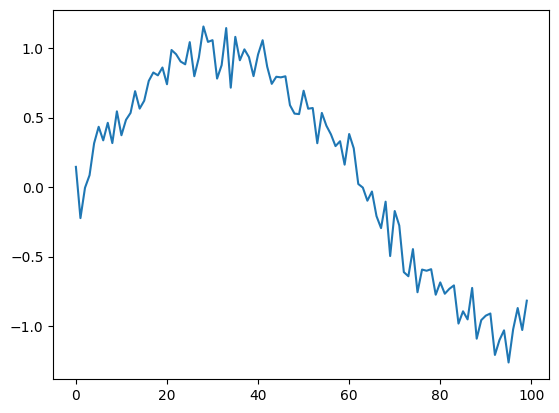

In [4]:
N = 10000
data = np.array([np.sin(x/20) for x in range(N)]) + 0.1*np.random.randn(N)
plt.plot(data[:100])

In [47]:
# У нас есть 3 отсчета ДО угадываемого элемента и 3 отсчета после угадываемого элемента
off = 3
length = off*2+1
X = np.array([np.diag(np.hstack((data[i:i+off],data[i+off+1:i+length]))) for i in range(N-length)])
Y = data[off:N-off-1]
print(f'{X.shape}, {Y.shape}')

(9993, 6, 6), (9993,)


In [49]:
model= Sequential () # инициализация пустой модели
model.add(Input((length -1,length-1)))
model.add(Bidirectional(GRU(2))) 
model.add(Dense(1, activation = 'linear')) 
model.summary()

model.compile(loss = 'mean_squared_error', metrics= ['accuracy'], optimizer = Adam(0.01))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 4)                 120       
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 125 (500.00 Byte)
Trainable params: 125 (500.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
history = model.fit(X,Y,batch_size =32, epochs =10)

Epoch 1/10
313/313 [==============================] - 7s 6ms/step - loss: 0.0200 - accuracy: 0.0000e+00
Epoch 2/10
313/313 [==============================] - 2s 6ms/step - loss: 0.0121 - accuracy: 0.0000e+00
Epoch 3/10
313/313 [==============================] - 2s 6ms/step - loss: 0.0119 - accuracy: 0.0000e+00
Epoch 4/10
313/313 [==============================] - 2s 7ms/step - loss: 0.0116 - accuracy: 0.0000e+00
Epoch 5/10
313/313 [==============================] - 2s 6ms/step - loss: 0.0116 - accuracy: 0.0000e+00
Epoch 6/10
313/313 [==============================] - 2s 6ms/step - loss: 0.0115 - accuracy: 0.0000e+00
Epoch 7/10
313/313 [==============================] - 2s 7ms/step - loss: 0.0116 - accuracy: 0.0000e+00
Epoch 8/10
313/313 [==============================] - 2s 7ms/step - loss: 0.0115 - accuracy: 0.0000e+00
Epoch 9/10
313/313 [==============================] - 2s 7ms/step - loss: 0.0115 - accuracy: 0.0000e+00
Epoch 10/10
313/313 [==============================] - 2s 7ms/st

In [86]:
M =200
XX = np.zeros(M)

In [87]:
XX[:off] = data[:off]

In [88]:
for i in range(M-off-1):
    x = np.diag(np.hstack((XX[i:i+off], data[i+off+1:i+length])))
    x = np.expand_dims(x,axis =0)
    y = model.predict(x)
    XX[i+off+1]=y
    
plt.plot(XX[:M])
plt.plot(data[:M])
plt.show()

1/1 [==============================] - 0s 26ms/step


C:\Users\Колонтай\AppData\Local\Temp\ipykernel_4576\1521732187.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  XX[i+off+1]=y


1/1 [==============================] - 0s 27ms/step


# АВТОЭНКОДЕРЫ

Тип нейронной сети используемый для сжатия признаков (уменьшении размерности). Сжатое латентное представления может к примеру подавать в обычных задачах, таких как классификация. 

### Простой автоэнкодер

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Input,Reshape

(x_train, y_train), (x_test,y_test) = mnist.load_data()
# стандартизация входных данных 
x_train = x_train/ 255
x_test = x_test/ 255
x_train = np.reshape(x_train, (len(x_train),28,28,1))
x_test = np.reshape(x_test, (len(x_test),28,28,1))

input_img = Input((28,28,1))
x = Flatten()(input_img)
x = Dense(128, activation = 'relu')(x)
x = Dense(64, activation = 'relu') (x)
encoded = Dense(49, activation = 'relu')(x)

d = Dense (64, activation = 'relu')(encoded)
d = Dense(28*28, activation = 'sigmoid')(d)
decoded = Reshape((28,28,1))(d)

autoencoder = keras.Model(input_img, decoded, name = "autoencoder") # указываем коллекцию входных и выходных слоев
autoencoder.compile (optimizer = 'adam',loss = 'mean_squared_error')
batch_size = 100
autoencoder.fit(x_train,x_train, epochs = 20, batch_size = batch_size, shuffle = True)

n =10 
imgs = x_test[:n]
decoded_imgs = autoencoder.predict(x_test[:n], batch_size = n)

plt.figure(figsize = (n,2))
for i in range (n):
    ax = plt.subplot(2,n,i+1)
    plt.imshow(imgs[i].squeeze(), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax2 = plt.subplot(2,n,i+n+1)
    plt.imshow(decoded_imgs[i].squeeze(), cmap = 'gray')
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)

### VAE автоэнкодер

Epoch 1/5
600/600 [==============================] - 28s 36ms/step - loss: 0.0397
Epoch 2/5
600/600 [==============================] - 14s 24ms/step - loss: 0.0241
Epoch 3/5
600/600 [==============================] - 25s 41ms/step - loss: 0.0234
Epoch 4/5
600/600 [==============================] - 20s 34ms/step - loss: 0.0231
Epoch 5/5
1/1 [==============================] - 0s 84ms/step


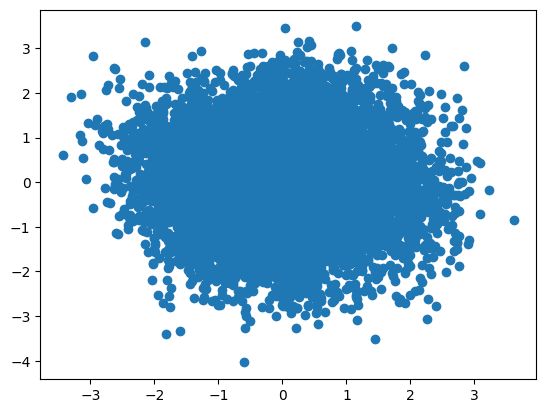

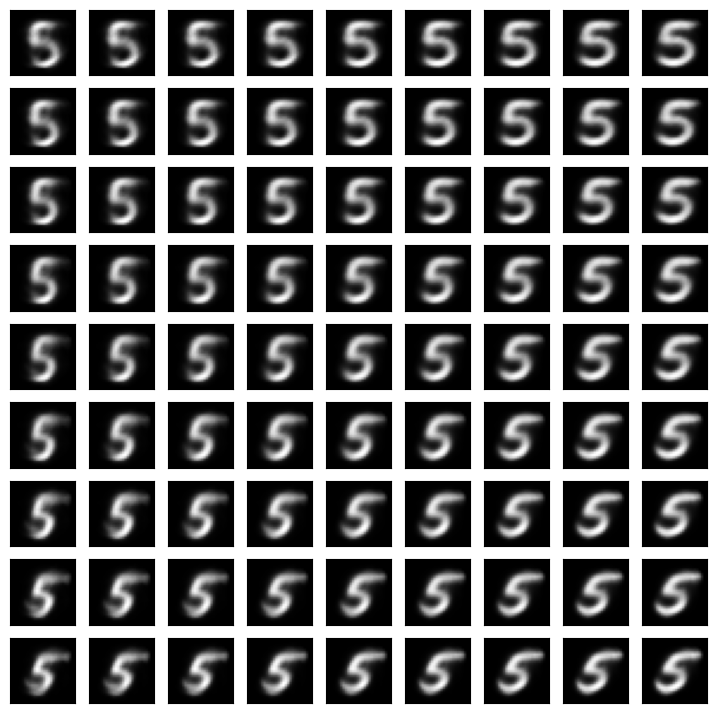

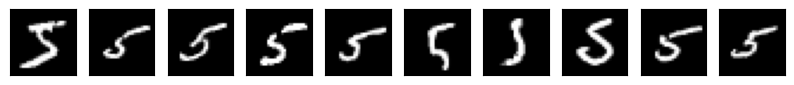

1/1 [==============================] - 0s 362ms/step


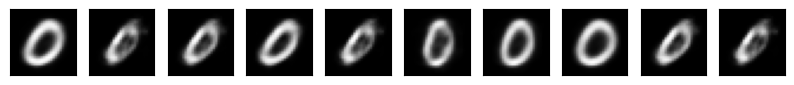

1/1 [==============================] - 0s 79ms/step


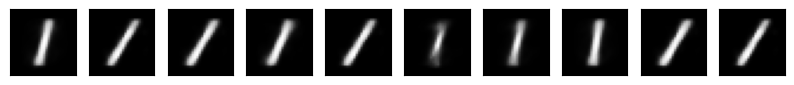

1/1 [==============================] - 0s 56ms/step


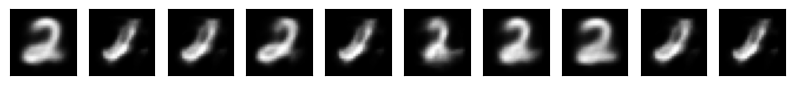

1/1 [==============================] - 0s 51ms/step


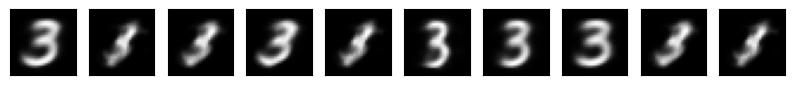

1/1 [==============================] - 0s 48ms/step


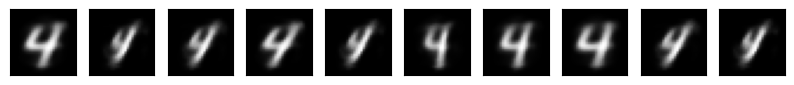

1/1 [==============================] - 0s 46ms/step


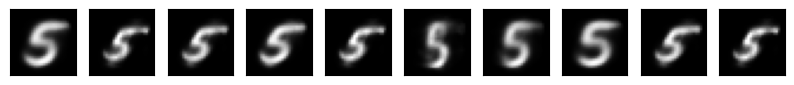

1/1 [==============================] - 0s 48ms/step


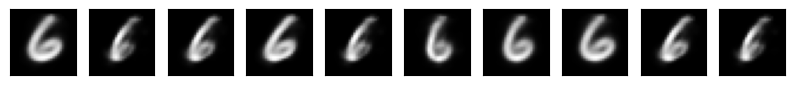

1/1 [==============================] - 0s 54ms/step


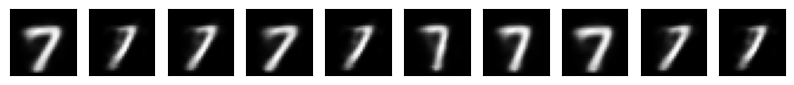

1/1 [==============================] - 0s 51ms/step


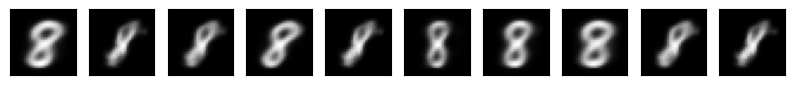

1/1 [==============================] - 0s 55ms/step


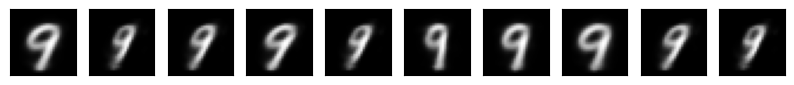

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Lambda, BatchNormalization, Dropout
from tensorflow.keras.layers import concatenate

hidden_dim = 2
num_classes = 10
batch_size = 100  # должно быть кратно 60 000 и 10 0000

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# стандартизация входных данных
x_train = x_train / 255
x_test = x_test / 255

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)


def dropout_and_batch(x):
    return Dropout(0.3)(BatchNormalization()(x))

input_img = Input(shape=(28, 28, 1))
fl = Flatten()(input_img)
lb = Input(shape=(num_classes,))
x = concatenate([fl, lb])
x = Dense(256, activation='relu')(x)
x = dropout_and_batch(x)
x = Dense(128, activation='relu')(x)
x = dropout_and_batch(x)

z_mean2 = Dense(hidden_dim)(x)
z_log_var = Dense(hidden_dim)(x)

def noiser(args):
    global z_mean, z_log_var
    z_mean, z_log_var = args
    N = K.random_normal(shape=(batch_size, hidden_dim), mean=0., stddev=1.0)
    return K.exp(z_log_var / 2) * N + z_mean



h = Lambda(noiser, output_shape=(hidden_dim,))([z_mean2, z_log_var])

input_dec = Input(shape=(hidden_dim,))
lb_dec = Input(shape=(num_classes,))
d = concatenate([input_dec, lb_dec])
d = Dense(128, activation='elu')(d)
d = dropout_and_batch(d)
d = Dense(256, activation='elu')(d)
d = dropout_and_batch(d)
d = Dense(28*28, activation='sigmoid')(d)
decoded = Reshape((28, 28, 1))(d)

encoder = keras.Model([input_img, lb], h, name='encoder')
decoder = keras.Model([input_dec, lb_dec], decoded, name='decoder')
cvae = keras.Model([input_img, lb, lb_dec], decoder([encoder([input_img, lb]), lb_dec]), name="cvae")

z_meaner = keras.Model([input_img, lb], z_mean2)
tr_style = keras.Model([input_img, lb, lb_dec], decoder([z_meaner([input_img, lb]), lb_dec]), name='tr_style')

def vae_loss(x,y):
    x = K.reshape(x, shape = (batch_size,28*28))
    y = K.reshape(y, shape = (batch_size,28*28))
    loss = K.sum(K.square(x-y), axis =-1)
    kl_loss = -0.5*K.sum(1+z_log_var - K.square(z_mean) - K.exp(z_log_var), axis =-1)
    return (loss +kl_loss)/2/28/28

    
cvae.compile(optimizer='adam', loss=vae_loss)
cvae.fit([x_train, y_train_cat, y_train_cat], x_train, epochs=5, batch_size=batch_size, shuffle=True)

lb = lb_dec = y_test_cat
h = encoder.predict([x_test, lb], batch_size=batch_size)
plt.scatter(h[:, 0], h[:, 1])


n = 4
total = 2*n+1
input_lbl = np.zeros((1, num_classes))
input_lbl[0, 5] = 1

plt.figure(figsize=(total, total))

h = np.zeros((1, hidden_dim))
num = 1
for i in range(-n, n+1):
    for j in range(-n, n+1):
        ax = plt.subplot(total, total, num)
        num += 1
        h[0, :] = [1*i/n, 1*j/n]
        img = decoder.predict([h, input_lbl])
        plt.imshow(img.squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


def plot_digits(*images):
    images = [x.squeeze() for x in images]
    n = min([x.shape[0] for x in images])
    
    plt.figure(figsize=(n, len(images)))
    for j in range(n):
        for i in range(len(images)):
            ax = plt.subplot(len(images), n, i*n + j + 1)
            plt.imshow(images[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()
    


dig1 = 5
dig2 = 2

num = 10
X = x_train[y_train == dig1][:num]

lb_1 = np.zeros((num, num_classes))
lb_1[:, dig1] = 1

plot_digits(X)

for i in range(num_classes):
    lb_2 = np.zeros((num, num_classes))
    lb_2[:, i] = 1

    Y = tr_style.predict([X, lb_1, lb_2], batch_size=num)
    plot_digits(Y)

In [21]:
encoder

# GAN Generative Adversarial Networks
Есть генератор и есть дискриминатор 

Генератор генерирует образцы
Дискриминатор пытается отличить сгенерированные образцы от реальных. Оба обучаются. Генерация изображений. Перенос стилей. Видео, Аудио

Схематичное изображение ----> натуральное изображение

Низкое качество изображения ----> высокое качество изображение